In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid
import copy
from copy import copy, deepcopy
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb



In [2]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [3]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

#     print(alpha, alpha_err)

In [4]:
Set_Mapping([1,3,4,5,2])
nqubit=2
C=20
shots=4000
depth=[2,4,8]

results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0


20
20
20


In [5]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/d=2 13452 FT R/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)

paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/2023-05-16 eab explicit CNOT FT R__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/2023-05-16 eab__d=8_explicit CNOT FT R/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

['2023-05-16-195131_Line_001.txt', '2023-05-16-195213_Line_002.txt', '2023-05-16-195256_Line_003.txt', '2023-05-16-195337_Line_004.txt', '2023-05-16-195537_Line_005.txt', '2023-05-16-195621_Line_006.txt', '2023-05-16-195703_Line_007.txt', '2023-05-16-195744_Line_008.txt', '2023-05-16-195943_Line_009.txt', '2023-05-16-200028_Line_010.txt', '2023-05-16-200111_Line_011.txt', '2023-05-16-200152_Line_012.txt', '2023-05-16-200351_Line_013.txt', '2023-05-16-200434_Line_014.txt', '2023-05-16-200516_Line_015.txt', '2023-05-16-200559_Line_016.txt', '2023-05-16-200758_Line_017.txt', '2023-05-16-200840_Line_018.txt', '2023-05-16-200923_Line_019.txt', '2023-05-16-201005_Line_020.txt']
['2023-05-16-201540_Line_001.txt', '2023-05-16-201631_Line_002.txt', '2023-05-16-205640_Line_003.txt', '2023-05-16-205731_Line_004.txt', '2023-05-16-205822_Line_005.txt', '2023-05-16-210030_Line_006.txt', '2023-05-16-210122_Line_007.txt', '2023-05-16-210213_Line_008.txt', '2023-05-16-212300_Line_009.txt', '2023-05-16-

In [13]:
a=Quantum_State(5)
# a_s=Quantum_State(5)
# b_c=Quantum_Circuit(5,"qc")
sampled_shots=2000
fidelity_list_bootstrap={}
for j in range (10):
    filenames_data=[]
    counts_d2=[]
    counts_d2_spam=[]
    counts=[]
    counts_spam=[]
    filenames_data=filenames_d2.copy()
    paf_data=paf_data_d2
    circuit=c_d2
    for i in range (len(filenames_data)):
#         print (filenames_data[i])
        a=Quantum_State(5)
        a.Import_random_sample(paf_data+filenames_data[i],keep_file=True,sample=(shots,1000))
        data_traced=Trace_Out(a,[0,1,2,3])
        counts=[round(sampled_shots*x) for x in  data_traced.population]
#         print ("counts:", counts)
        counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#         print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
        counts_d2.append(counts_ibm_mapping_dic)

    filenames_data=[]
    counts_d4=[]
    counts_d4_spam=[]
    counts=[]
    counts_spam=[]
    filenames_data=filenames_d4.copy()
#     print (filenames_data)
    # print (len(filenames_data))
    paf_data=paf_data_d4
    circuit=c_d4
    for i in range (len(filenames_data)):
#         print (filenames_data[i])
        a.Import_random_sample(paf_data+filenames_data[i],keep_file=True,sample=(shots,2000))
        data_traced=Trace_Out(a,[0,1,2,3])
        counts=[round(sampled_shots*x) for x in  data_traced.population]
        counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        counts_d4.append(counts_ibm_mapping_dic)


    filenames_data=[]
    counts_d8=[]
    counts_d8_spam=[]
    counts=[]
    counts_spam=[]
    filenames_data=filenames_d8.copy()
    # print (filenames_data)
    # # print (len(filenames_data))
    paf_data=paf_data_d8
    circuit=c_d8
    for i in range (len(filenames_data)):
#         print (filenames_data[i])
        a.Import_random_sample(paf_data+filenames_data[i],keep_file=True,sample=(shots,2000))
        data_traced=Trace_Out(a,[0,1,2,3])
        counts=[round(sampled_shots*x) for x in  data_traced.population]
        counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        counts_d8.append(counts_ibm_mapping_dic)


    with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/9c845ecd-7110-4fa0-bea0-9287796dc4e5XX13452noS_explicitCNOT_FT_Rrotations0516", "rb") as fp:   # Unpickling
        eab_load = pickle.load(fp)

    eab_load_cpy=deepcopy(eab_load[0:60])
    eab_load_cpy_spam=deepcopy(eab_load[0:60])


    for i in range (C):
    #     print (i)
        assert eab_load_cpy[i]["L"]==2
        eab_load_cpy[i]["counts"]=counts_d2[i].copy()

    for i in range (C,2*C):
    #     print (i)
        assert eab_load_cpy[i]["L"]==4
        eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()


    for i in range (2*C,3*C):
    #     print (i)
        assert eab_load_cpy[i]["L"]==8
        eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()

#     print (eab_load_cpy)
    pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full
    eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy, pauli_request_list)
    raw_fidelity_list = eab_result["fidelity_list"]
#     print (raw_fidelity_list)
#     plot_dic={}
#     error_dic={}
    fidelity_list = {}
    stdev_list = {}
#     a248_dic={}
#     Y248_dic={}
#     Yerr248_dic={}
    for pauli_label in pauli_request_list:
        if(pauli_label == 'I'*nqubit):
            fidelity_list[pauli_label] = 1.0
            stdev_list[pauli_label] = 0.0
        else:
            alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
            fidelity_list[pauli_label] = alpha #pauli fidelity from fit
            stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
#             a248_dic[pauli_label]=a 
#             Y248_dic[pauli_label]=Y
#             Yerr248_dic[pauli_label]=Yerr
#     print (fidelity_list)
    fidelity_list_bootstrap[j]={}    
    fidelity_list_bootstrap[j]=fidelity_list    
    
    print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
    use_density_matrix=False
    use_readout_error =False
    if use_density_matrix:
        print("Density matrix based simulation")
    else:
        print("Measurement based simulation, shots = %d" % shots)

    if use_readout_error is True:
        print("Measurement bitflip rate = %f" % eps_readout)
    else:
        print("No readout error")

    # Average fidelity
    print("Total error = ", 1-np.mean(list(fidelity_list.values())))

    print("Label / Pauli infidelity / Standard deviation")
    for pauli_label in pauli_request_list:
        print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
#         plot_dic[pauli_label[::-1]]=round(1-fidelity_list[pauli_label],7)
#         error_dic[pauli_label[::-1]]=round (stdev_list[pauli_label],7)
    
    print ("repitition",j)
    j+=1

#     plot_248={}
#     plot_248=deepcopy(plot_dic)
#     err_248=deepcopy(error_dic)
#     print (Y248_dic)

    # x_c=np.linspace(0,8,num=80)
    # nqubit=2
    # fig, axs = plt.subplots(4, 4)
    # fig.set_figwidth(20)
    # fig.set_figheight(15)
    # fig.subplots_adjust(hspace=0.5,wspace=0.3) 
    # fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
    # fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
    # for i in range (4):
    #     for j in range(4):
    #         pauli_label=pauli_request_list[4*i+j]
    #         if (pauli_label == 'I'*nqubit):
    # #                 fidelity_list[pauli_label] = 1.0
    # #                 stdev_list[pauli_label] = 0.0
    #             pass
    #         else:
    #             axs[i, j].set_xticks([2,4,8])   
    #             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
    #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
    #             axs[i, j].set_title(pauli_label[::-1])

    # for pauli_label in pauli_request_list:
    # fig.savefig("fit.pdf", format="pdf", dpi=500)   

Parameters: n = 2, C = 20,  L =  [2, 4, 8]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.07130683360050605
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0776496 0.0047657
YI 0.0818189 0.0054711
ZI 0.0179124 0.0021405
IX 0.0691222 0.0064286
XX 0.12409 0.0089137
YX 0.1081091 0.0089937
ZX 0.0687572 0.007892
IY 0.0722455 0.0071814
XY 0.1169128 0.0084678
YY 0.1222854 0.0093376
ZY 0.0723069 0.0075191
IZ 0.0235035 0.0023487
XZ 0.0884285 0.0054711
YZ 0.0849321 0.0054537
ZZ 0.0128352 0.0024797
repitition 0
Parameters: n = 2, C = 20,  L =  [2, 4, 8]
Measurement based simulation, shots = 4000
No readout error
Total error =  0.07130683360050605
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0776496 0.0047657
YI 0.0818189 0.0054711
ZI 0.0179124 0.0021405
IX 0.0691222 0.0064286
XX 0.12409 0.0089137
YX 0.1081091 0.0089937
ZX 0.0687572 0.007892
IY 0.0722455 0.0071814
XY 0.1169128 0.0084678
YY 0.1222854 0.0093376
ZY 0.0723069 0.0075191
IZ 0.

In [18]:
print (fidelity_list_bootstrap)

{0: {'II': 1.0, 'IX': 0.9223503969258371, 'IY': 0.91818110717606, 'IZ': 0.9820876289982414, 'XI': 0.9308777767965644, 'XX': 0.8759099893352488, 'XY': 0.8918909494889977, 'XZ': 0.9312428107144317, 'YI': 0.9277544981844715, 'YX': 0.8830871611328152, 'YY': 0.8777145794020317, 'YZ': 0.9276930821207757, 'ZI': 0.9764964529815813, 'ZX': 0.911571470298193, 'ZY': 0.9150679269387132, 'ZZ': 0.9871648318979402}, 1: {'II': 1.0, 'IX': 0.9223503969258371, 'IY': 0.91818110717606, 'IZ': 0.9820876289982414, 'XI': 0.9308777767965644, 'XX': 0.8759099893352488, 'XY': 0.8918909494889977, 'XZ': 0.9312428107144317, 'YI': 0.9277544981844715, 'YX': 0.8830871611328152, 'YY': 0.8777145794020317, 'YZ': 0.9276930821207757, 'ZI': 0.9764964529815813, 'ZX': 0.911571470298193, 'ZY': 0.9150679269387132, 'ZZ': 0.9871648318979402}, 2: {'II': 1.0, 'IX': 0.9223503969258371, 'IY': 0.91818110717606, 'IZ': 0.9820876289982414, 'XI': 0.9308777767965644, 'XX': 0.8759099893352488, 'XY': 0.8918909494889977, 'XZ': 0.9312428107144317

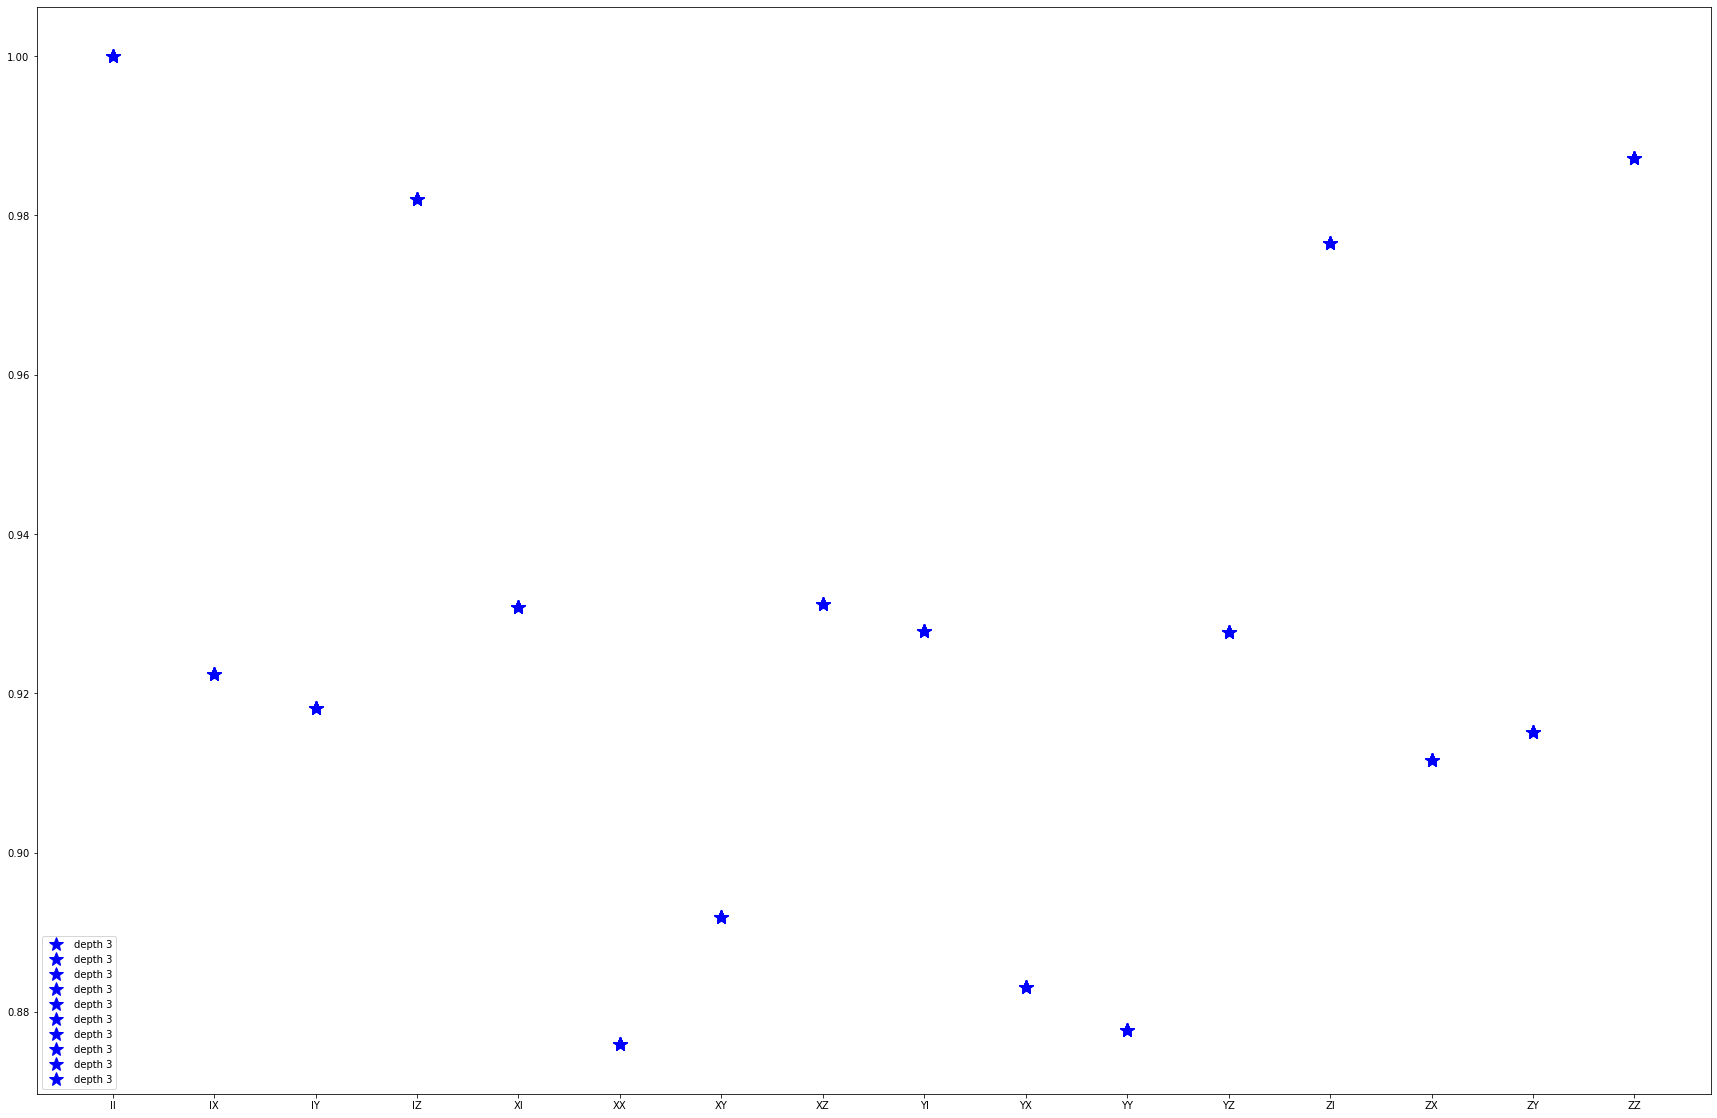

In [20]:
import seaborn as sns
sns.color_palette("PRGn",20)
plt.figure(figsize=(30,20))
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
for i in range (10):
    plt.plot(pauli_request_list,[fidelity_list_bootstrap[i][pauli_label] for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
plt.legend()

In [ ]:
# filenames_data=[]
# counts_d4=[]
# counts_d4_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d4.copy()
# print (filenames_data)
# # print (len(filenames_data))
# paf_data=paf_data_d4
# circuit=c_d4
# for i in range (len(filenames_data)):
#     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d4.append(counts_ibm_mapping_dic)
    
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d4_spam.append(counts_ibm_mapping_dic_spam)

#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
#     Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])
# # #         

In [ ]:
# filenames_data=[]
# counts_d8=[]
# counts_d8_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d8.copy()
# # print (filenames_data)
# # # print (len(filenames_data))
# paf_data=paf_data_d8
# circuit=c_d8
# for i in range (len(filenames_data)):
#     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
#     Display_States_Population(states=[sim_traced,data_traced,data_traced_spam],label=["sim_traced","data_traced","spam_traced"])

In [ ]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [ ]:
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/9c845ecd-7110-4fa0-bea0-9287796dc4e5XX13452noS_explicitCNOT_FT_Rrotations0516", "rb") as fp:   # Unpickling
#     eab_load = pickle.load(fp)

# eab_load_cpy=deepcopy(eab_load[0:60])
# eab_load_cpy_spam=deepcopy(eab_load[0:60])
# # eab_load_cpy_24=deepcopy(eab_load[0:20]) #a copy that only has depth=[2,4]


In [ ]:
# for i in range (C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==2
#     eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
# for i in range (C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==2
#     eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# # for i in range (C):
# #     print (eab_load_cpy[i]["counts"])
# #     print (eab_load_cpy_spam[i]["counts"])

In [ ]:
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==4
#     eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy[i]["counts"])
    
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==4
#     eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy_spam[i]["counts"])

# # for i in range (C,2*C):
# #     print (eab_load_cpy[i]["counts"])
# #     print (eab_load_cpy_spam[i]["counts"])    

In [ ]:
# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==8
#     eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy[i])

# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==8
#     eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy_spam[i]["counts"])

# # for i in range (2*C,3*C):
# #     print (eab_load_cpy[i]["counts"])
# #     print (eab_load_cpy_spam[i]["counts"])    

In [ ]:
# # print (eab_load_cpy)
# filename = str(uuid.uuid4())
# filename+="FTXX13452_noSE_explicitCNOT_R_0516_00+11_ExperimentalData"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/"+filename, "wb") as fp:
#     pickle.dump(eab_load_cpy, fp)


In [ ]:
# sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
# import EAB_process_modified 
# import itertools
# import pdb

# '''Specify a set of Pauli you want to estimate'''
# C=10
# C=20
# nqubit=2
# depth=[2,4,8]
# pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

# #process_EAB(Lrange, cb_data, pauli_request_list)
# eab_result=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)
# # eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

# print (eab_result)


In [ ]:
# from scipy.optimize import curve_fit
# def rcs_fit_fun_depth1(x, alpha):
#         #return a * np.exp(-alpha * x)
#         return alpha ** x

# def fit_EAB_depth1(X, xeb_list):
#     Y = [np.mean(xeb_list[L]) for L in X]
#     Yerr = [sem(xeb_list[L]) for L in X]
#     #print(linregress(X,np.log(Y)))
    
    
#     try:
#         params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
#         alpha = params[0]
#         params_err = np.sqrt(np.diag(pcov))
#         alpha_err = params_err[0]

#     except RuntimeError:
#         alpha = 1.0
#         alpha_err = 0.0


#     return alpha, alpha_err

#     print(alpha, alpha_err)

In [ ]:
# raw_fidelity_list = eab_result["fidelity_list"]

# #######depth=[2]#########
# ##########################
# plot_dic={}
# error_dic={}
# err=[]
# # sys.exit(0)
# depth=[2]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_2={}
# plot_2=deepcopy(plot_dic)
# err_2=deepcopy(error_dic)

# #######depth=[2]#########
# ##########################
# plot_dic={}
# err=[]
# # sys.exit(0)
# depth=[2,4]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_24={}
# plot_24=deepcopy(plot_dic)
# err_24=deepcopy(error_dic)

# #######depth=[2]#########
# ##########################
# plot_dic={}
# error_dic={}
# error_dic={}
# err=[]
# # sys.exit(0)
# depth=[2,4,8]
# fidelity_list = {}
# stdev_list = {}

# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha
#         stdev_list[pauli_label] = alpha_err

# # print(fidelity_list)

# # print(stdev_list)

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
#     error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

# plot_248={}
# plot_248=deepcopy(plot_dic)
# err_248=deepcopy(error_dic)


In [ ]:
# def rcs_fit_fun(x, a, alpha):
#         #return a * np.exp(-alpha * x)
#         return a * (alpha ** x)

# def fit_EAB_plot(X, xeb_list):
#     Y = [np.mean(xeb_list[L]) for L in X]
#     Yerr = [sem(xeb_list[L]) for L in X]
#     #print(linregress(X,np.log(Y)))
    
    
#     try:
#         params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
#         alpha = params[1]
#         a=params[0]
#         params_err = np.sqrt(np.diag(pcov))
#         alpha_err = params_err[1]

#     except RuntimeError:
#         alpha = 1.0
#         alpha_err = 0.0

#     # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
#     # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


#     # print(params)

#     return alpha,a, alpha_err,Y, Yerr

#     print(alpha, alpha_err)




In [ ]:
# raw_fidelity_list = eab_result["fidelity_list"]
# plot_dic={}
# error_dic={}
# # sys.exit(0)
# depth=[2,4,8]
# fidelity_list = {}
# stdev_list = {}
# a248_dic={}
# Y248_dic={}
# Yerr248_dic={}
# for pauli_label in pauli_request_list:
#     if(pauli_label == 'I'*nqubit):
#         fidelity_list[pauli_label] = 1.0
#         stdev_list[pauli_label] = 0.0
#     else:
#         alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
#         fidelity_list[pauli_label] = alpha #pauli fidelity from fit
#         stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
#         a248_dic[pauli_label]=a 
#         Y248_dic[pauli_label]=Y
#         Yerr248_dic[pauli_label]=Yerr

# print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
# use_density_matrix=False
# use_readout_error =False
# shots=4000
# if use_density_matrix:
#     print("Density matrix based simulation")
# else:
#     print("Measurement based simulation, shots = %d" % shots)

# if use_readout_error is True:
#     print("Measurement bitflip rate = %f" % eps_readout)
# else:
#     print("No readout error")

# # Average fidelity
# print("Total error = ", 1-np.mean(list(fidelity_list.values())))

# print("Label / Pauli infidelity / Standard deviation")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
#     plot_dic[pauli_label[::-1]]=round(1-fidelity_list[pauli_label],7)
#     error_dic[pauli_label[::-1]]=round (stdev_list[pauli_label],7)
# # print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# # for pauli_label in pauli_request_list:
# #     print(pauli_label[::-1], fidelity_list[pauli_label])

# plot_248={}
# plot_248=deepcopy(plot_dic)
# err_248=deepcopy(error_dic)
# print (Y248_dic)

# x_c=np.linspace(0,8,num=80)
# nqubit=2
# fig, axs = plt.subplots(4, 4)
# fig.set_figwidth(20)
# fig.set_figheight(15)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
# #                 fidelity_list[pauli_label] = 1.0
# #                 stdev_list[pauli_label] = 0.0
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8])   
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
#             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
                
# # for pauli_label in pauli_request_list:
# # fig.savefig("fit.pdf", format="pdf", dpi=500)        

In [ ]:
# error_list = fidelity_to_error(fidelity_list,nqubit)
# print("Label / Pauli error rates")
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], round(error_list[pauli_label],7))


spam results